[EN]
# Training a Neural Network

In this LAB, you'll train a compact convolutional neural network (CNN) on CIFAR-10 dataset, explore different optimizers, test normalization and dropout strategies, and see how data augmentation changes model performance.

By the end of this LAB you should be able to:

* Build and train a small CNN with PyTorch.

* Explain differences between common optimizers (SGD, Momentum, Adam, RMSProp, AdaGrad).

* Understand the benefits of regularization techniques, such as normalization and Dropout.

* Implement and test simple data augmentations and measure their effect.

To use this notebook, just run cells sequentially.

[VN]
# Huấn luyện một mạng nơ ron

Trong buổi thực hành, ta sẽ huấn luyện một mạng nơ ron tích chập nhỏ (CNN) trên bộ dữ liệu CIFAR-10, khám phá các bộ tối ưu khác nhau, kiểm tra sự chuẩn hoá và các chiến lược bỏ-quên (dropout), và xem xét làm sao dữ liệu tăng cường sẽ thay đổi hiệu quả của mô hình.

Kết thúc buổi thực hành, ta có thể thực hiện

* Xây dựng và huấn luyện một mạng nơ ron nhỏ trong PyTorch

* Giải thích được sự khác biệt giữa các bộ tối ưu phổ biến (SGD, Momentum, Adam, RMSProp, AdaGrad).

* Hiều được lợi ích của các kỹ thuật chống học quá như chuẩn hoá hay bỏ-quên.

* Cài đặt và kiểm tra dữ liệu tăng cường và đo sự hiệu quả của nó

Để dùng sổ tay này, chỉ cần chạy các ô mã nguồn một cách tuần tự

## Setup and imports


In [ ]:
# Standard imports and environment setup
import os, time, copy, random
from pathlib import Path
from typing import Dict, Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

# reproducibility
RND_SEED = 42
random.seed(RND_SEED)
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)

# device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# output directory
OUT_DIR = Path('cnn_practice_out')
OUT_DIR.mkdir(exist_ok=True)


Device: cuda


[EN]
## Model architecture

In this section, we'll define a simple CNN for image classification. This network consists of convolutional layers and a classification head, which is a fully-connected neural network. Now, your task is to implement a class `SmallCNN` given the architecture in the image. Here are some additional details:
* The padding and stride of every convolutional layer is 1.

* The kernel size of each convolutional layer is 3.

* The kernel size of each `MaxPool` layer is 2.

* The penultimate layer of the classification head uses `ReLU` as the activation function.

* The output layer uses  the `softmax` as activation function

[VN]
## Kiến trúc mô hình

Trong phần này, ta sẽ định nghĩa một mạng nơ ron tích chập đơn giản dành cho bài toán phân loại hình ảnh. Mạng nơ ron này bao gồm các tầng tích chập và một đầu phân loại vốn là lớp mạng nơ ron kết nối đầy đủ. Bây giờ, công việc của bạn là cài đặt lớp `SmallCNN` có kiến trúc được minh hoạ dưới đây. Ngoài ra còn có các thông tin bổ sung như sau :

* Các viền và bước nhẩy của các tầng tích chập đều là 1

* Kích thước nhân của các tầng tích chập đều là 3

* Kích thước nhân của các tầng giảm mẫu `MaxPool` là 2

* Các lớp trước đầu ra phân loại đều dùng hàm kích hoạt `ReLU`

* Lớp đầu ra dùng hàm đầu ra `softmax`

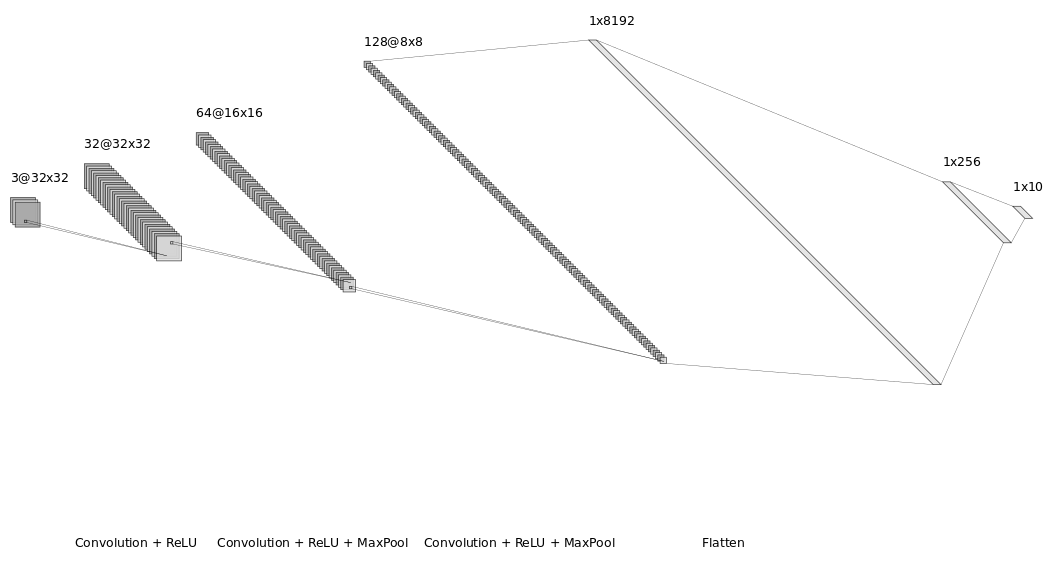
---
[EN] The abbreviation D@HxW means respectively depth, high, and width sizes of  the convolutional layer.

[VN] Viết tắt D@HxW nghĩa là các kích thước độ sâu, cao và rộng của lớp nơ ron tích chập.
```



In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        ## TODO: your implementation here

    def forward(self, x):
        ## TODO: your implementation here


[EN]
## The CIFAR-10 dataset
The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The CIFAR-10 dataset contains 60K of 32x32 color images in 10 different classes that are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6K images of each class. For the dataset loading, it's able to   

* Normalize color histogram

* Transform into tensor

[VN]
## Bộ dữ liệu CIFAR-10
Bộ dữ liệu CIFAR-10 là một bộ ảnh thường dùng cho huấn luyện giải thuật học máy và thị giác máy tính. Bộ dữ liệu CIFAR-10 chứa 60K ảnh mầu kích thước 32x32 gán 10 lớp nhãn chúng là máy bay, ô tô, chim, mèo, hươu, chó, ếch, máy bay, tầu và xe tải. Có 6K ảnh tương ứng mỗi lớp. Để tài bộ dữ liêu, ta cân có

* Chuẩn hoá mầu ảnh

* Chuyển sang tensor


In [ ]:
def get_dataloaders(dataset_name: str = 'CIFAR10', batch_size: int = 128, quick: bool = False):
    if dataset_name.upper() == 'CIFAR10':

        # Normalize the same as ImageNet

        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2470, 0.2435, 0.2616)

        train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        root = './data'
        train_set = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_transforms)
        test_set = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_transforms)
        num_classes = 10

    else:
        raise ValueError('Unsupported dataset')

    if quick:
        # Small subset for demonstration
        if hasattr(train_set, 'data'):
            train_set.data = train_set.data[:2000]
        if hasattr(train_set, 'targets'):
            train_set.targets = train_set.targets[:2000]
        if hasattr(test_set, 'data'):
            test_set.data = test_set.data[:1000]
        if hasattr(test_set, 'targets'):
            test_set.targets = test_set.targets[:1000]

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader, num_classes


[EN]

## Training
Here are the implementation of 2 function `train_one_epoch` and `evaluate`, which are used for training and evaluation. In PyTorch, for almost all models, the training procedure consists of the following key steps:

- Move inputs and targets to the same device as the model (GPU).
- Zero optimizer gradients (`optimizer.zero_grad()`). If you forget to call this function, gradients will accumulate across iterations.
- Compute the loss and backpropagate (via `loss.backward()`).
- Update weights based on the current weights and the computed gradients (`optimizer.step()`).

[VN]
## Huấn luyện
Đây là phần cài đặt của hai hàm `train_one_epoch` và `evaluate`, chúng được dùng cho pha huấn luyện và đánh giá. Trong PyTorch, với hầu hết các mô hình, thủ tục huấn luyện bao gồm các bước quan trọng như sau :

- Chuyển dữ liệu đầu vào, đích đến cùng mô hình đến thiết bị tính toán (thường là GPU)
- Xác lập đạo hàm (gradients) của bộ tối ưu về không (`optimizer.zero_grad()`). Nếu ta muốn gọi hàm này, đạo hàm sẽ được tổng hợp theo từng vòng lặp.
- Tính toán lỗi và lan truyền ngược (bằng cách `loss.backward()`).
- Tính toán đạo hàm và cập nhật trọng số hiện tại (bằng cách `optimizer.step()`).  



In [ ]:
# Training and evaluation loops
def train_one_epoch(model: nn.Module, loader, criterion, optimizer, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        _, preds = out.max(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total

def evaluate(model: nn.Module, loader, criterion, device: torch.device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            _, preds = out.max(1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return running_loss / total, correct / total


[EN]

Now, let's train our model for 10 epochs, using an SGD optimizer.

[VN]

Bây giờ, hãy huấn luyện mô hình với 10 vòng lặp, sử dụng bộ tối ưu SGD

In [ ]:
num_epochs = 10

train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
model = SmallCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_params, lr=1e-3)

best_val_acc = 0.0
best_model = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())

    if verbose:
        print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")

[EN]

Saving the best checkpoint

[VN]

Sao lưu lại mô hình tốt nhất



In [ ]:
model_path = OUT_DIR / "demo_SGD.pth"
if best_model is not None:
    torch.save(best_model, model_path)

[EN]
## Optimizer selection

Switching the optimizer can dramatically change training dynamics. This section runs the same model with different optimizers and plots training loss and validation accuracy across epochs.

Now, your task is to implement some optimizers, namely SGD (with / without momentum), Adagrad, RMSprop and Adam. Additionally, you can take a look at torch.optim documentation link for more optimizers.

[VN]
## Lựa chọn bộ tối ưu

Thay đổi lựa chọn bộ tối ưu có thể gây sự thay đổi lớn khi huấn luyện. Phần tiếp theo ta sẽ chạy một mô hình với nhiều bộ tối ưu khác nhau và vẽ các hàm mất mát và thực hiện đánh giá chéo tại mỗi vòng lặp.

Nhiệm vụ bây giờ là cài đặt các bộ tối ưu  SGD (có / không có momentum), Adagrad, RMSprop và Adam. Ta cần đọc thêm hướng dẫn torch.optim để hiểu thêm các tham số của các bộ tối ưu.






In [ ]:
# Optimizer factory
def get_optimizer(name: str, model_params, lr: float = 1e-3, momentum: float = 0.9, weight_decay: float = 0.0):
    name = name.lower()
    if name == 'sgd':
        ## TODO: your implementation here
    elif name == 'sgd_momentum':
        ## TODO: your implementation here
    elif name == 'adagrad':
        ## TODO: your implementation here
    elif name == 'rmsprop':
        ## TODO: your implementation here
    elif name == 'adam':
        ## TODO: your implementation here
    else:
        raise ValueError(f"Unknown optimizer: {name}")


In [ ]:
# Helper function for running experiment
def optimizer_run_experiment(
    exp_name: str,
    optimizer_name: str,
    lr: float,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNN(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'optimizer': optimizer_name,
        'lr': lr,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def optimizer_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = optimizer_run_experiment(
            exp_name=name,
            optimizer_name=cfg.get('optimizer', 'adam'),
            lr=cfg.get('lr', 1e-3),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['optimizer']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[EN]

Training our model with different optimizers

[VN]

Huấn luyện mô hình với nhiều bộ tối ưu


Running 1/5: opt_sgd
[opt_sgd] Epoch 1/50 | train loss 2.3024 acc 0.1045 | val loss 2.3022 acc 0.0960 | time 0.9s
[opt_sgd] Epoch 2/50 | train loss 2.3022 acc 0.1075 | val loss 2.3021 acc 0.0970 | time 0.9s
[opt_sgd] Epoch 3/50 | train loss 2.3020 acc 0.1090 | val loss 2.3019 acc 0.1020 | time 0.8s
[opt_sgd] Epoch 4/50 | train loss 2.3018 acc 0.1125 | val loss 2.3017 acc 0.1040 | time 0.9s
[opt_sgd] Epoch 5/50 | train loss 2.3016 acc 0.1150 | val loss 2.3015 acc 0.1040 | time 0.9s
[opt_sgd] Epoch 6/50 | train loss 2.3013 acc 0.1135 | val loss 2.3013 acc 0.1080 | time 0.9s
[opt_sgd] Epoch 7/50 | train loss 2.3012 acc 0.1200 | val loss 2.3011 acc 0.1080 | time 1.1s
[opt_sgd] Epoch 8/50 | train loss 2.3010 acc 0.1225 | val loss 2.3009 acc 0.1160 | time 1.4s
[opt_sgd] Epoch 9/50 | train loss 2.3008 acc 0.1280 | val loss 2.3008 acc 0.1190 | time 1.3s
[opt_sgd] Epoch 10/50 | train loss 2.3006 acc 0.1355 | val loss 2.3006 acc 0.1260 | time 1.2s
[opt_sgd] Epoch 11/50 | train loss 2.3004 acc 0.

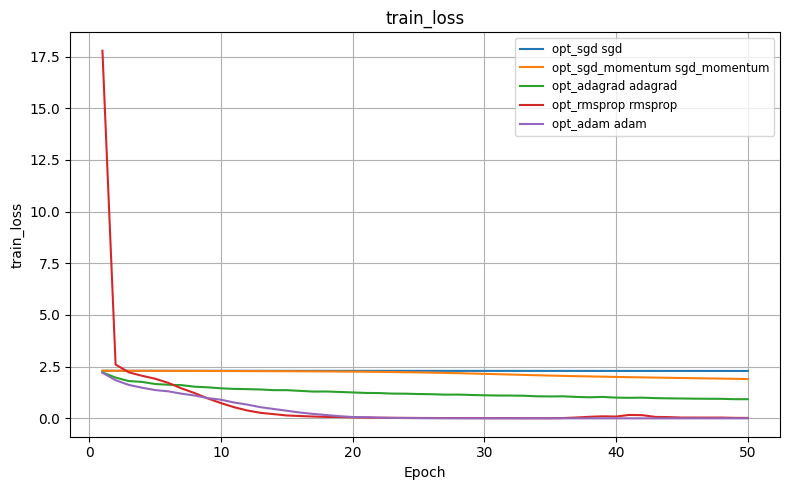

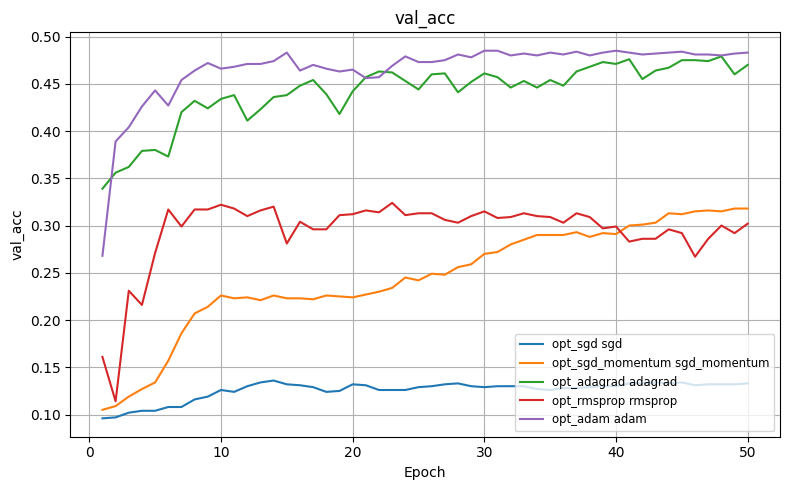

In [ ]:
quick_debug = True
num_epochs = 50

base_lr = 1e-3
exps = []

## Add any optimizer that you want to try here.
optimizers = []

for opt in optimizers:
      exps.append({
          'name': f"opt_{opt}",
          'optimizer': opt,
          'lr': base_lr,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = optimizer_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'optimizer_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'optimizer', 'lr', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['optimizer'], r['lr'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot train loss validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

## Normalization technique selection

Normalization layers can help stabilize and speed up training. In this section you will train identical networks with BatchNorm, InstanceNorm, GroupNorm and no normalization to compare their training convergence speed and validation accuracy.

Let's define a function `norm_layer(channels)`. This functions takes `channels`, which is the number of channels of the input tensor, as the input, and output a normalization layer.

[VN]

## Lựa chọn kỹ thuật chuẩn hoá

Các lớp chuẩn hoá cho phép ổn định và tăng tốc quá trình huấn luyện. Trong phần này, ta sẽ huấn luyện các mạng nơ ron có chuẩn hoá (theo bó, theo mẫu, theo nhóm) và so sánh không chuẩn hoá với tiêu chí tốc độ hội tụ và độ chính xác trên tập đánh giá.

Hãy định nghĩa hàm `norm_layer(channels)` với tham số đầu vào `channels` là số kênh của tensor đầu vào, còn đầu ra của hàm là lớp đã chuẩn hoá.



In [ ]:
class SmallCNNWithNormalization(nn.Module):
    def __init__(self, norm=None, num_classes=10):

        super().__init__()
        self.norm = norm

        def norm_layer(channels):
            # Feel free to add as many normalization techniques as you want!
            if norm is None:
                ## TODO: your implementation here
            elif norm == 'batch':
                ## TODO: your implementation here
            elif norm == 'instance':
                ## TODO: your implementation here
            elif norm == 'group':
                ## TODO: your implementation here
            else:
                raise ValueError("The normalization technique is not supported")

        # Copy your implementation of SmallCNN here. Make sure to add norm_layer to your architecture.

    def forward(self, x):
        # Copy your implementation of SmallCNN here

In [ ]:
# Helper function for running experiments
def normalization_run_experiment(
    exp_name: str,
    norm: str | None,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNNWithNormalization(num_classes=num_classes, norm=norm).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'norm': norm,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def normalization_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = normalization_run_experiment(
            exp_name=name,
            norm=cfg.get('norm', None),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['norm']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[EN]

Let's try some normalization techniques that you've just implemented.

[VN]

Hãy thử một vài kỹ thuật chuẩn hoá mà ta vừa cài đặt

In [ ]:
quick_debug = True
num_epochs = 50

exps = []

## Add any normalization technique that you want to try here.
norms = [None]

for norm in norms:
      exps.append({
          'name': f"norm_{norm}",
          'norm': norm,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = normalization_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'normalization_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'norm', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['norm'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

## Dropout

Dropout randomly zeros activations during training to reduce co-adaptation of neurons and to regularize models. This section sweeps through dropout probabilities and shows how validation accuracy changes.


[VN]

## Bỏ-mặc

Kỹ thuật bỏ-mặc sẽ không kích hoạt một cách ngẫu nhiên các nơ ron trong quá trình huấn luyện để giảm thiểu tính đồng-tương thích và tăng tính điều phối trong mô hình. Trong phần này ta sẽ thay đổi tỷ lệ xác suất kỹ thuật bổ-mặc và sự thay đổi tỷ lệ chính xác trong tập đánh giá.

In [ ]:
class SmallCNNWithNormalizationAndDropout(nn.Module):
    def __init__(self, norm=None, dropout_p=0.0, num_classes=10):

        super().__init__()
        self.norm = norm
        self.dropout_p = dropout_p

        def norm_layer(channels):
            ## Copy your norm_layer implementation here.

        # Copy your implementation of SmallCNNWithNormalization here. Add dropout layers wherever you want.

    def forward(self, x):
        # Copy your implementation of SmallCNNWithNormalization here.

In [ ]:
# Helper function for running experiments
def dropout_run_experiment(
    exp_name: str,
    dropout_p: float,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', batch_size=batch_size, quick=quick)
    model = SmallCNNWithNormalizationAndDropout(num_classes=num_classes, norm='batch', dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")

    # save results
    out = {
        'exp_name': exp_name,
        'dropout_p': norm,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def dropout_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = dropout_run_experiment(
            exp_name=name,
            dropout_p=cfg.get('dropout_p', 0.0),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['dropout_p']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
quick_debug = True
num_epochs = 50

exps = []
# Add any dropout probability that you want here
dropout_p_list = []

for dropout_p in dropout_p_list:
      exps.append({
          'name': f"dropout_{dropout_p}",
          'dropout_p': dropout_p,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = dropout_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'dropout_results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'dropout_p', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['dropout_p'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='val_acc')


[EN]

## Data augmentation

Data augmentation increases training dataset diversity on the fly, and is known to reduce overfitting. Let's go back to the helper function to load the CIFAR-10 dataset and add data augmentation there. In this part, we will use [`RandomCrop`](https://docs.pytorch.org/vision/0.22/generated/torchvision.transforms.RandomCrop.html) and [`RandomHorizontalFlip`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) for augmentation.

[VN]

## Tăng cường dữ liệu

Tăng cường dữ liệu làm tăng tính đa dạng của tập dữ liệu huấn luyện, và cũng được biết đến như cách làm giảm vấn đề quá khớp. Quay lại với hàm dùng để tải dữ liệu CIFAR-10 và bổ sung kỹ thuật tăng cường dữ liệu tại đây. Trong phần này, ta sẽ dùng hai kỹ thuật [`RandomCrop`](https://docs.pytorch.org/vision/0.22/generated/torchvision.transforms.RandomCrop.html) và [`RandomHorizontalFlip`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html)




In [ ]:
def get_dataloaders(dataset_name: str = 'CIFAR10', use_augmentation=False, batch_size: int = 128, quick: bool = False):
    """Return train and test dataloaders and number of classes.
    quick: if True, uses smaller subsets for faster debugging.
    """
    if dataset_name.upper() == 'CIFAR10':

        # Normalize the same as ImageNet

        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2470, 0.2435, 0.2616)

        if use_augmentation:
            train_transforms = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        else:
            train_transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        root = './data'
        train_set = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_transforms)
        test_set = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_transforms)
        num_classes = 10

    else:
        raise ValueError('Unsupported dataset')

    if quick:
        # Small subset for debugging
        if hasattr(train_set, 'data'):
            train_set.data = train_set.data[:2000]
        if hasattr(train_set, 'targets'):
            train_set.targets = train_set.targets[:2000]
        if hasattr(test_set, 'data'):
            test_set.data = test_set.data[:1000]
        if hasattr(test_set, 'targets'):
            test_set.targets = test_set.targets[:1000]

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader, num_classes


In [ ]:
# Helper function for running experiments
def augmentation_run_experiment(
    exp_name: str,
    use_augmentation: bool,
    num_epochs: int = 10,
    batch_size: int = 128,
    quick: bool = False,
    verbose: bool = True,
):
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10', use_augmentation=use_augmentation, batch_size=batch_size, quick=quick)
    model = SmallCNN(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), lr=1e-3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        if verbose:
            print(f"[{exp_name}] Epoch {epoch}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
                  f"val loss {val_loss:.4f} acc {val_acc:.4f} | time {time.time()-t0:.1f}s")


    # save results
    out = {
        'exp_name': exp_name,
        'use_augmentation': use_augmentation,
        'num_epochs': num_epochs,
        'best_val_acc': best_val_acc,
        'history': history,
    }
    # save model
    model_path = OUT_DIR / f"{exp_name}_best.pth"
    if best_model is not None:
        torch.save(best_model, model_path)
    return out


In [ ]:
# Utilities for running batched experiments and plotting
def augmentation_grid_experiments(exps: List[Dict[str, Any]], quick: bool = False):
    results = []
    for i, cfg in enumerate(exps, 1):
        name = cfg.get('name', f"exp_{i}")
        print('=' * 80)
        print(f"Running {i}/{len(exps)}: {name}")
        res = augmentation_run_experiment(
            exp_name=name,
            use_augmentation=cfg.get('use_augmentation', False),
            num_epochs=cfg.get('num_epochs', 10),
            batch_size=cfg.get('batch_size', 128),
            quick=quick,
            verbose=True,
        )
        results.append(res)
    return results

def plot_history(results: List[Dict[str, Any]], key: str = 'val_acc'):
    plt.figure(figsize=(8, 5))
    for r in results:
        hist = r['history'][key.replace('val_', 'val_')]
        epochs = list(range(1, len(hist) + 1))
        plt.plot(epochs, hist, label=f"{r['exp_name']} {r['use_augmentation']}")
    plt.xlabel('Epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[EN]

Let's see if data augmentation really works 🤔

[VN]

Kiểm tra xem kỹ thuật tăng cường dữ liệu hoạt động tốt 🤔

In [ ]:
# Running the experiment
quick_debug = True
num_epochs = 50

use_augmentation_list = [False, True]

exps = []

for use_augmentation in use_augmentation_list:
      exps.append({
          'name': f"augmentation_{use_augmentation}",
          'use_augmentation': use_augmentation,
          'num_epochs': num_epochs,
          'batch_size': 256,
      })

results = augmentation_grid_experiments(exps, quick=quick_debug)

# Save a simple CSV summary
import csv
csv_path = OUT_DIR / 'results_summary.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['exp_name', 'use_augmentation', 'best_val_acc'])
    for r in results:
        writer.writerow([r['exp_name'], r['use_augmentation'], r['best_val_acc']])
print(f"Saved summary to {csv_path}")

# Plot validation accuracies
plot_history(results, key='train_loss')
plot_history(results, key='val_acc')


[EN]

**Question:** Which augmentations might harm performance on CIFAR-10 ? Why?

[VN]

**Câu hỏi:** Kỹ thuật tăng cường nào có thể ảnh hường không tốt đến hiệu quả mô hình trên bộ dữ liệu CIFAR-10 ? Vì sao ?

[EN]

## Final suggestions
If you finished early, feel free to try these:
* Replace the simple CNN with a ResNet-like block and measure the performance difference.

* Implement weight decay sweeps and observe how regularization differs from dropout.

* Play with another dataset (such as MNIST, ImageNet)


[VN]

## Các khuyến nghị cuối cùng

Nếu bạn thực hiện xong sớm, có thể thử thêm các thí nghiệm khác :

* Thay mạng tích chập đơn giản bằng mạng khối giống ResNet và đo tính hiệu quả của nó

* Cài đặt suy giảm trọng số và quan sát xem nó điều phối khác gì so với kỹ thuật bỏ-mặc

* Thực nghiệm với các bộ dữ liệu khác như MNIST, ImageNet






